# **Машинное обучение ИБ-2024**

# **Домашнее задание 2.**
# Классификация, KNN, LogReg, SVC.

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:

    loss = np.mean(np.log(1 + np.exp(-y * np.dot(X, w) + w0)))

    l1 = gamma * np.linalg.norm(w, 1)
    l2 = beta * np.linalg.norm(w, 2)**2

    total_loss = loss + l1 + l2

    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    m = X.shape[0]

    z = np.dot(X, w) + w0
    predictions = 1 / (1 + np.exp(-y * z))

    grad_w = -(1/m) * np.dot((y * (1 - predictions)), X) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -(1/m) * np.sum(y * (1 - predictions))

    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        beta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []


    def fit(self, X, y):
        np.random.seed(self.random_state)
        m, n = X.shape
        self.w = np.random.randn(n)
        self.w0 = 0

        for i in range(self.max_iter):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, m, 64):
                end = start + 64
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                grad_w, grad_w0 = get_grad(X_batch, y_batch, self.w, self.w0, self.gamma, self.beta)

                self.w -= self.lr * grad_w
                self.w0 -= self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            if i > 1 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tolerance:
                break

    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        proba = self.predict_proba(X)[:, 1]
        return np.where(proba >= 0.5, 1, -1)


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        z = np.dot(X, self.w) + self.w0
        proba = 1 / (1 + np.exp(-z))
        return np.vstack([1 - proba, proba]).T



In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):

    colors = ['white' if label == 1 else 'black' for label in y]

    plt.scatter(X[:, 0], X[:, 1], c=colors, marker='o')
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.Paired)
    plt.show()

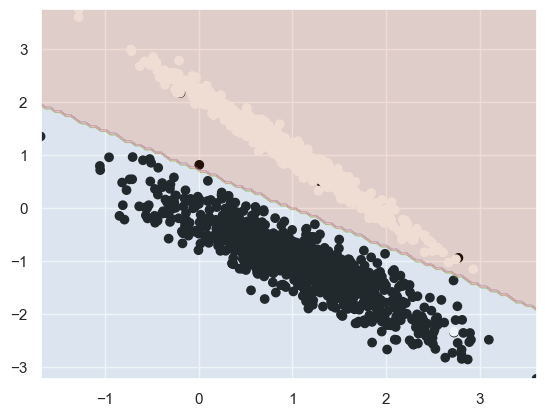

In [ ]:
model = Logit(0, 0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.plot(model.loss_history)
    plt.title("Изменение функции потерь в процессе обучения")
    plt.xlabel("Итерация")
    plt.ylabel("Функция потерь")
    plt.show()

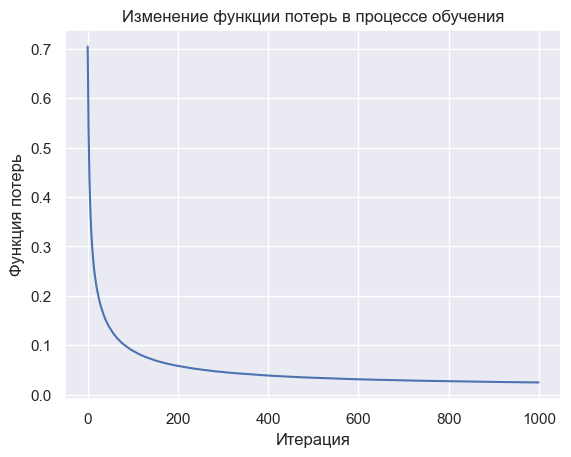

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_score(y_pred, y_true, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)

    return ({
        'Accuracy': round(accuracy, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1-Score': round(f1, 3),
        'AUC-ROC': round(auc_roc, 3)
    })


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.01, 0.1, 1, 10]

results = []

for kernel in kernels:
    for C in C_values:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        result = get_score(y_pred, y_test, y_proba)
        result['kernel'] = kernel
        result['C'] = C

        results.append(result)

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="AUC-ROC", ascending=False))


    Accuracy  Precision  Recall  F1-Score  AUC-ROC   kernel      C
1      0.994      0.992   0.996     0.994    0.999   linear   0.10
2      0.994      0.992   0.996     0.994    0.999   linear   1.00
3      0.994      0.992   0.996     0.994    0.999   linear  10.00
8      0.989      0.996   0.981     0.988    0.999      rbf   0.01
9      0.994      0.992   0.996     0.994    0.999      rbf   0.10
10     0.994      0.992   0.996     0.994    0.999      rbf   1.00
0      0.994      0.992   0.996     0.994    0.998   linear   0.01
12     0.943      0.987   0.893     0.938    0.996  sigmoid   0.01
6      0.994      0.992   0.996     0.994    0.995     poly   1.00
11     0.994      0.992   0.996     0.994    0.995      rbf  10.00
4      0.994      0.992   0.996     0.994    0.994     poly   0.01
5      0.994      0.992   0.996     0.994    0.994     poly   0.10
7      0.994      0.992   0.996     0.994    0.994     poly  10.00
13     0.920      0.882   0.966     0.922    0.981  sigmoid   

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):

        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict_proba(self, X):
        n_samples = X.shape[0]
        probabilities = np.zeros((n_samples, len(np.unique(self.y_train))))

        distances = cdist(X, self.X_train, metric=self.metric)

        for i in range(n_samples):
            neighbors_indices = np.argsort(distances[i])[:self.n_neighbors]
            neighbor_labels = self.y_train[neighbors_indices]
            for label in np.unique(self.y_train):
                probabilities[i, label] = np.sum(neighbor_labels == label) / self.n_neighbors

        return probabilities

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.where(np.argmax(probabilities, axis=1) == 1, 1, -1)

In [ ]:
knn = KNNClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

for metric, value in get_score(y_pred, y_test, y_proba).items():
    print(f'{metric}: {value}')


Accuracy: 0.981
Precision: 0.967
Recall: 0.996
F1-Score: 0.981
AUC-ROC: 0.994


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
df = pd.read_csv('train.csv')
train_df = df[:50000]
test_df = df[50000:]
df

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59995,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,59996,1,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,59997,8,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,59998,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

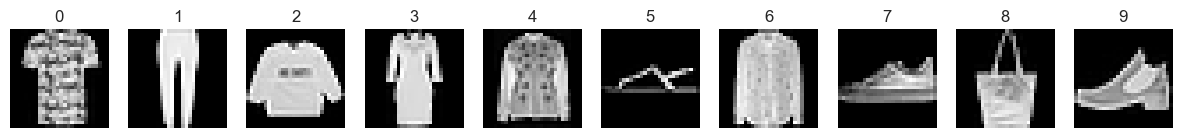

In [ ]:
unique_classes = df['Category'].unique()

fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 5))\

for cat in range(len(unique_classes)):
    sample_image = df[df['Category'] == cat].iloc[0, 2:].values
    sample_image = sample_image.reshape(28, 28)

    axes[cat].imshow(sample_image, cmap='gray')
    axes[cat].set_title(cat)
    axes[cat].axis('off')

plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train = train_df.iloc[:, 2:].values
y_train = train_df['Category'].values

X_test = test_df.iloc[:, 2:].values
y_test = test_df['Category'].values

standard_scaler = StandardScaler()
X1_train = standard_scaler.fit_transform(X_train)
X1_test = standard_scaler.transform(X_test)

minmax_scaler = MinMaxScaler()
X2_train = minmax_scaler.fit_transform(X_train)
X2_test = minmax_scaler.transform(X_test)

#### 11. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

logreg_params = {
    'C': [0.01, 1],
    'max_iter': [200, 300, 500]
}
logreg = LogisticRegression()
logreg_grid_search = GridSearchCV(logreg, logreg_params, cv=5, scoring='accuracy')
logreg_grid_search.fit(X1_train, y_train)

best_logreg_model = logreg_grid_search.best_estimator_
logreg_y_pred = best_logreg_model.predict(X1_test)
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)

print(f'LogisticRegression: Best Parameters: {logreg_grid_search.best_params_}, Test Accuracy: {logreg_accuracy:.4f}')


c:\Users\dsave\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dsave\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

LogisticRegression: Best Parameters: {'C': 0.01, 'max_iter': 300}, Test Accuracy: 0.8562


c:\Users\dsave\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
knn_params = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'cosine', 'minkowski']
}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy')
knn_grid_search.fit(X1_train, y_train)

best_knn_model = knn_grid_search.best_estimator_
knn_y_pred = best_knn_model.predict(X1_test)
knn_accuracy = accuracy_score(y_test, knn_y_pred)

print(f'KNeighborsClassifier: Best Parameters: {knn_grid_search.best_params_}, Test Accuracy: {knn_accuracy:.4f}')

KNeighborsClassifier: Best Parameters: {'metric': 'cosine', 'n_neighbors': 5}, Test Accuracy: 0.8621


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Если у всех объектов в датасете одинаковые признаки, то для логистической регрессии это будет означать отсутствие полезной информации для разделения классов. Модель не сможет найти значимых параметров для определения разницы между положительным и отрицательным классами, поскольку все объекты имеют одинаковые значения признаков.

При обучении на стохастическом градиентном спуске (SGD) градиенты будут равны нулю или почти нулю, так как нет разницы в признаках, и модель не сможет двигаться к какому-либо решению.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.